Effective charge of HF is -0.4688158269027078 atomic units


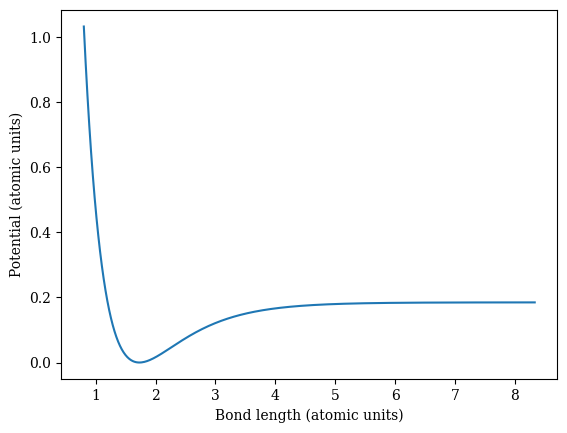

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from morse import Morse
from numpy import linalg as la
from matplotlib import cm
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.size'] = 10


# Atom masses in atomic mass units
mH, mF = 1., 19.

# Equilibrium bondlength in meters
re = 0.915801e-10

# dipole moment of HF at the equilibrium bondlength
dipole_au = -0.8113388

# frequency of second overtone in cm^-1
omega_p_so_wn = 3979.09
omega_p_so_au = omega_p_so_wn / 219474.63068


# potential energy at minimum, ok to set at zero
Te = 0

# Morse parameters in atomic units 
we_au, wexe_au = 0.01911889333688861, 0.0004944018798851136
# Morse parameters in wavenumbers
we, wexe = 4196.112054123941, 108.50866999528301

# create Morse object 
X = Morse(mH, mF, we, wexe, re, Te, dipole_au, 0.001, omega_p_so_au)

# create Morse grid - will make grids in SI (self.r) and atomic units (self.r_au)
X.make_rgrid()

# create Morse potential on SI grid, will make potential in SI (self.V) and atomic units (self.V_au)
X.V = X.Vmorse(X.r)


print(F'Effective charge of HF is {X.q_au} atomic units')


# plot Morse potential in atomic units
plt.plot(X.r_au, X.V_au)
plt.xlabel("Bond length (atomic units)")
plt.ylabel("Potential (atomic units)")
plt.show()

In [2]:
De_au = X.De * 2.294e+17 

a_au = X.a / 1.89e+10

k = 2 * De_au * a_au ** 2
print(k)
g = -6 * De_au * a_au ** 3
print(g)
h = 14 * De_au * a_au ** 4
print(h)

0.6329039482333795
-2.484237023530717
7.584095368683646


Recall the three coupled Hamiltonians:
p dot A Hamiltonian,
\begin{equation}
    \hat{H}_{\rm p \cdot A} = \frac{\hat{p}^2}{2m} + V(\hat{x})  + \hbar \omega \hat{b}^{\dagger} \hat{b} -  \frac{z}{m} \hat{p} \cdot  {\bf A}_0 ( \hat{b}^{\dagger} + \hat{b}) + \frac{z^2}{2m}  {\bf A}_0^2 ( \hat{b}^{\dagger} + \hat{b})^2,
\end{equation}
the d dot E Hamiltonian,
\begin{equation}
    \hat{H}_{\rm d \cdot E} = \frac{\hat{p}^2}{2m} + V(\hat{x}) + \hbar \omega \hat{b}^{\dagger} \hat{b} + i\omega \hat{\mu} \cdot {\bf A}_0 ( \hat{b}^{\dagger} - \hat{b}) +\frac{\omega_{{\rm cav}}}{\hbar} ( \hat{\mu} \cdot {\bf A}_0)^2
\end{equation}
or the Pauli-Fierz (PF) Hamiltonian,
\begin{equation}
    \hat{H}_{\rm d \cdot E} = \frac{\hat{p}^2}{2m}+ V(\hat{x}) + \hbar \omega \hat{b}^{\dagger} \hat{b} - \omega \hat{\mu} \cdot {\bf A}_0 ( \hat{b}^{\dagger} + \hat{b}) +\frac{\omega_{{\rm cav}}}{\hbar} ( \hat{\mu} \cdot {\bf A}_0)^2
\end{equation}

The matter Hamiltonian terms $\frac{\hat{p}^2}{2m} + V(\hat{x})$ have been solved by either our Morse, quartic perturbation, or finite difference approach and our photon Hamiltonian term $\hbar \omega \hat{b}^{\dagger} \hat{b}$ is also already known.  We need to evaluate 
the additional coupling elements.  For the d.E and PF Hamiltonians, the coupling elements will involve matter matrix elements with of the form 
\begin{equation}
\langle \psi_i | \hat{\mu} | \psi_f \rangle = z \langle \psi_i | \hat{x} | \psi_f \rangle
\end{equation}
and the p.A Hamiltonian will have matrix elements of the form
\begin{equation}
\langle \psi_i | \hat{p} | \psi_f \rangle = i m \left(E_i - E_f \right) \langle \psi_i | \hat{x} | \psi_f \rangle
\end{equation}
where $E_n$ is the energy associated with matter state $n$, $m$ is the reduced mass, and $i$ is the imaginary unit.  Hence, we need to be able to compute matrix elements of the position operator with our matter states.  


In [3]:
# Build mixed matter - photon basis
X.photon_dim = 10
X.matter_dim = 10
X.build_basis()
print(" Basis states")
print(X.basis)
print(X.q_au)

 Basis states
[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (9, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (9, 4), (0, 5), (1, 5), (2, 5), (3, 5), (4, 5), (5, 5), (6, 5), (7, 5), (8, 5), (9, 5), (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (9, 6), (0, 7), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (6, 7), (7, 7), (8, 7), (9, 7), (0, 8), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9)]
-0.4688158269027078


In [4]:
# plot lowest 4 eigenvalues for each representation
A_vals = np.array([0, 0.002, 0.004, 0.006, 0.008, 0.010, 0.012, 0.014, 0.016, 0.018, 0.02]) 

N_roots = len(X.basis)

pda_vals = np.zeros((11,N_roots))
dde_vals = np.zeros((11,N_roots))
pf_vals = np.zeros((11,N_roots))

idx = 0
for Av in A_vals:
    X.A0_au = Av
    X.build_d_dot_E_Hamiltonian()
    X.build_p_dot_A_Hamiltonian()
    X.build_PF_Hamiltonian()
    vals_PdA, vecs_PdA = la.eigh(X.H_p_dot_A)
    vals_DdE, vecs_EdE = la.eigh(X.H_d_dot_E)
    vals_PF, vecs_PF = la.eigh(X.H_PF)
    pda_vals[idx,:] = np.copy(vals_PdA)
    dde_vals[idx,:] = np.copy(vals_DdE)
    pf_vals[idx,:] = np.copy(vals_PF)
    idx += 1


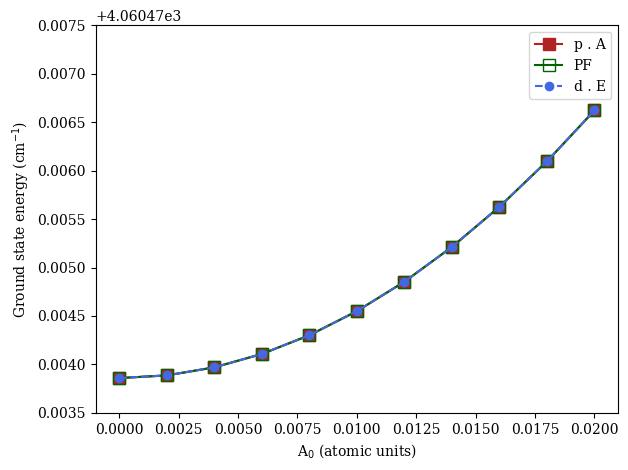

In [5]:
COLOUR1 = "firebrick"
COLOUR2 = "darkgreen"
COLOUR3 = "royalblue"
COLOUR4 = "rebeccapurple"
COLOUR5 = 'darkorchid'
COLOUR6 = 'olivedrab'
    
plt.plot(A_vals, pda_vals[:,0] * X.au_to_wn, color=COLOUR1, linestyle="solid", marker="s", ms="8", mfc=COLOUR1, label="p . A")
plt.plot(A_vals, pf_vals[:,0] * X.au_to_wn, color=COLOUR2, linestyle="solid", marker="s", ms="8", mfc="none", label="PF")
plt.plot(A_vals, dde_vals[:,0] * X.au_to_wn, color=COLOUR3, linestyle="dashed", marker="o", ms="6", mfc=COLOUR3, label="d . E")
plt.ylim(4060.4735,4060.4775)
plt.xlabel("A$_0$ (atomic units)")
plt.ylabel("Ground state energy (cm$^{-1}$)")
plt.tight_layout()
plt.legend()
plt.savefig("Ground_state_coupled_system_fundamental_all_hamiltonians.png", dpi=200)
plt.show()


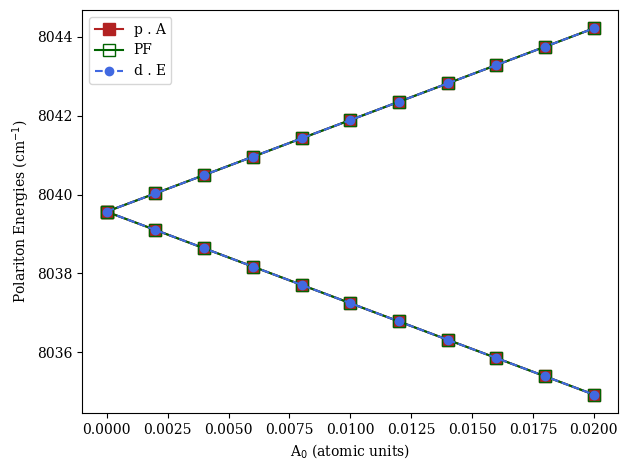

In [6]:
plt.plot(A_vals, pda_vals[:,1] * X.au_to_wn, color=COLOUR1, linestyle="solid", marker="s", ms="8", mfc=COLOUR1, label="p . A")
plt.plot(A_vals, pf_vals[:,1] * X.au_to_wn, color=COLOUR2, linestyle="solid", marker="s", ms="8", mfc="none", label="PF")
plt.plot(A_vals, dde_vals[:,1] * X.au_to_wn, color=COLOUR3, linestyle="dashed", marker="o", ms="6", mfc=COLOUR3, label="d . E")
plt.plot(A_vals, pda_vals[:,2] * X.au_to_wn, color=COLOUR1, linestyle="solid", marker="s", ms="8", mfc=COLOUR1)
plt.plot(A_vals, pf_vals[:,2] * X.au_to_wn, color=COLOUR2, linestyle="solid", marker="s", ms="8", mfc="none")
plt.plot(A_vals, dde_vals[:,2] * X.au_to_wn, color=COLOUR3, linestyle="dashed", marker="o", ms="6", mfc=COLOUR3)
plt.xlabel("A$_0$ (atomic units)")
plt.ylabel("Polariton Energies (cm$^{-1}$)")
plt.tight_layout()
plt.legend()
plt.savefig("Polariton_Energies_coupled_system_fundamental_all_hamiltonians.png", dpi=200)
plt.show()

In [7]:
pda_Rabi_splitting_au = pda_vals[10,2]-pda_vals[10,1]
pda_Rabi_splitting_wn = pda_Rabi_splitting_au * X.au_to_wn

dde_Rabi_splitting_au = dde_vals[10,2]-dde_vals[10,1]
dde_Rabi_splitting_wn = dde_Rabi_splitting_au * X.au_to_wn

pf_Rabi_splitting_au = pf_vals[10,2]-pf_vals[10,1]
pf_Rabi_splitting_wn = pf_Rabi_splitting_au * X.au_to_wn

print(F' The p.A Rabi splitting in atomic units is {pda_Rabi_splitting_au:8.2e}')
print(F' The p.A Rabi splitting in wavenumbers is  {pda_Rabi_splitting_wn:8.2f}')
print(F' The d.E Rabi splitting in atomic units is {dde_Rabi_splitting_au:8.2e}')
print(F' The d.E Rabi splitting in wavenumbers is  {dde_Rabi_splitting_wn:8.2f}')
print(F' The PF Rabi splitting in atomic units is  {pf_Rabi_splitting_au:8.2e}')
print(F' The PF Rabi splitting in wavenumbers is   {pf_Rabi_splitting_wn:8.2f}')
      

 The p.A Rabi splitting in atomic units is 4.23e-05
 The p.A Rabi splitting in wavenumbers is      9.29
 The d.E Rabi splitting in atomic units is 4.23e-05
 The d.E Rabi splitting in wavenumbers is      9.29
 The PF Rabi splitting in atomic units is  4.23e-05
 The PF Rabi splitting in wavenumbers is       9.29


In [8]:
# build each Hamiltonian
X.build_p_dot_A_Hamiltonian()
X.build_d_dot_E_Hamiltonian()
X.build_PF_Hamiltonian()

# diagonalize each Hamiltonian
vals_PdA, vecs_PdA = la.eigh(X.H_p_dot_A)
vals_DdE, vecs_EdE = la.eigh(X.H_d_dot_E)
vals_PF, vecs_PF = la.eigh(X.H_PF)

In [9]:
x_avg = X.position_matrix_element(0, 0)
print(x_avg * X.q_au)
print(X.au_to_wn)

-0.8255014706095443
219474.63068


In [10]:
dipole_exp_00 = -0.8255014706095443
dipole_in = -0.8113388 
_expected_Rabi = 9.287223303551098

In [11]:
print(dipole_in -0.014162670609544311)

-0.8255014706095444


In [12]:
Rabi_Splitting = (pf_vals[10,2] - pf_vals[10,1]) * X.au_to_wn

In [13]:
print(Rabi_Splitting)

9.287219102956977


In [14]:
pf_vals[10,0] * X.au_to_wn

4060.4766199819364

In [15]:
PF_Ground_State_displaced_x_hat = 4060.4789770537204

In [16]:
print(X.q_au)

-0.4688158269027078


In [17]:
print(X.r_eq_au)
print(X.r_eq

1.7306130754164475


In [18]:
X.q_au * X.r_eq_au

-0.8113388